# Projet Python - Prediction of SXXP Returns

I.Mezzine, L.Schulcz

## Part II - EDA 

- Get the usual quick stats on raw returns to double-check the cleaning: expected dtypes = homogeneous, NaN/dim(Columns) <= NaN threshold
- Fill remainders with avg 
- Basic data discovery chart: plot SXXP rets v top-10 highest performers v top-10 worst performers over time 
- Check for seasonality and trend in data: using seasonal_decompose - theoretically shows no trend as we study returns 
- Remove noise: moving average over 3 days + wavelets (scale = 0.44)
- Show autocorrelations & cross correlations = prove market inefficiencies to justify forecasting

In [1]:
# Libraries 
import os 
import time
import sklearn as sk
import seaborn as sb 
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
from math import pow 
from numpy import concatenate
from scipy import signal,stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.pipeline import Pipeline
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, LSTM
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.callbacks import EarlyStopping, CSVLogger
from tensorflow.python.keras.constraints import max_norm
from tensorflow.python.keras import optimizers
import xgboost as xgb
import pywt as wt
import scikitplot as skplt
from scipy import stats
from scipy.optimize import minimize
import statsmodels.api as sm
import warnings 

warnings.simplefilter('ignore')
os.chdir('/home/fschulcz/Bureau/')

In [2]:
#Quick stats 
raw_rets =  pd.read_excel('/home/fschulcz/Bureau/SXXP_returns.xlsx')
sxxp = pd.read_excel('/home/fschulcz/Bureau/sxxp_returns_solo.xlsx')
raw_rets = raw_rets.apply(pd.to_numeric) #Turn all values to float 
initial_shape = raw_rets.shape #Get initial shape 
raw_rets = raw_rets.loc[:, (raw_rets != 0).any(axis=0)].copy() #Delete all empty columns
df_types_nan = pd.DataFrame(data = {'Type':raw_rets.dtypes,'NaN':raw_rets.isnull().sum()}) #Get Types & NaN
stats_fin = raw_rets.agg({u:{'Mean':np.mean, 
                         'Vol':np.std,
                         'Annualized Vol' : lambda u : np.sqrt(252)*u.std(),
                         'Kurtosis':lambda u : u.kurtosis(),
                         'Skewness':lambda u : u.skew(),
                         'Sharpe Ratio':lambda u: u.mean()/u.std()
}for u in raw_rets}) #Financial stats
desc = pd.merge(df_types_nan, stats_fin.T,left_index=True, right_index=True)
desc = pd.merge(desc,raw_rets.describe().T.iloc[:,3:], left_index=True, right_index=True) #merge quick stats
initial_NaN = desc.NaN.sum()
if initial_NaN != 0: #Fill na with avg
    raw_rets.fillna(raw_rets.mean()) 
    
print ('- Quick Stats Raw Returns - \nInitial Shape: ',initial_shape,'\nEmpty columns removed: ',\
      raw_rets.shape[1]-initial_shape[1],'\nNb values filled with columns avg :',initial_NaN,\
       '\nExtract:\n\n',desc.tail(10))


- Quick Stats Raw Returns - 
Initial Shape:  (491, 1303) 
Empty columns removed:  -383 
Nb values filled with columns avg : 0 
Extract:

                     Type  NaN  Annualized Vol    Kurtosis      Mean  \
WPG LN Equity    float64    0        0.234440  252.920056  0.000851   
WPP LN Equity    float64    0        0.287044   11.129085 -0.001322   
WRT1V FH Equity  float64    0        0.243197    2.937357 -0.000254   
WTB LN Equity    float64    0        0.221478   26.062382  0.000449   
YAR NO Equity    float64    0        0.253672    2.055945  0.000259   
YIT FH Equity    float64    0        0.300342    7.965530 -0.000253   
ZAL GY Equity    float64    0        0.327884    6.605560 -0.000576   
ZC FP Equity     float64    0        0.094062   75.887838  0.000123   
ZOT SQ Equity    float64    0        0.199265    7.278640 -0.000221   
ZURN SW Equity   float64    0        0.141709    3.146242  0.000452   

                 Sharpe Ratio   Skewness       Vol       min       25%  \
WPG LN

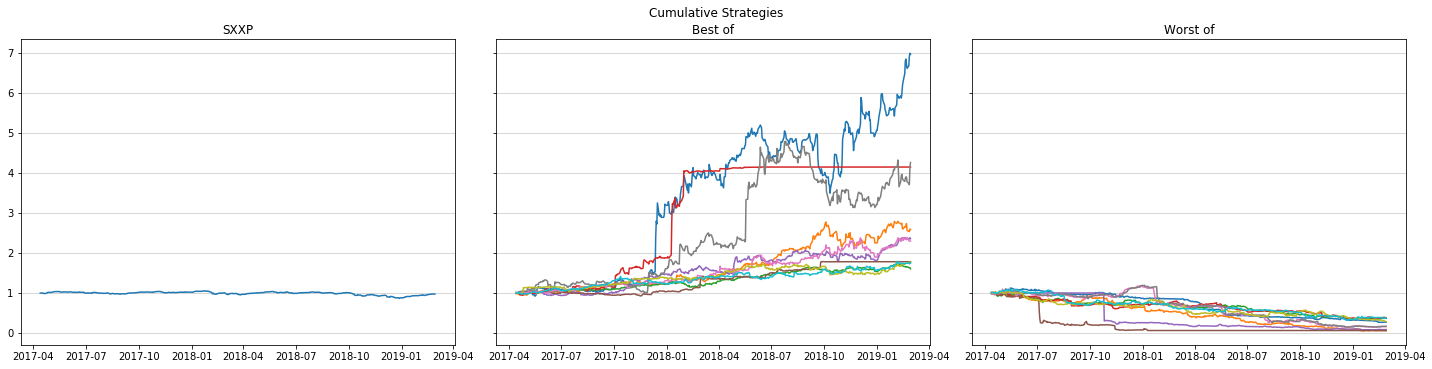

In [3]:
#SXXP cumulative strategy vs worst performers vs best performers (based on global Sharpe)
sxxp['SXXP_cum'] = (1+sxxp[['SXXP_index']]).cumprod()
bo_wo = desc.nlargest(10,'Sharpe Ratio').index.values.tolist() + desc.nsmallest(10,'Sharpe Ratio').index.values.tolist()
bo_wo_df = pd.DataFrame({})
for ticker in bo_wo: 
    bo_wo_df[[ticker+'_cum']] = (1+raw_rets[[ticker]]).cumprod()

    
# When line reaches a threshold, the stock has been unlisted
# Share y axis to allow for comparisons
f, (ax1,ax2,ax3) = plt.subplots(1,3, sharey = True, figsize=(20,5))
f.suptitle('Cumulative Strategies', va='bottom')
ax1.plot(sxxp.index.values,sxxp[['SXXP_cum']])
ax1.set_title('SXXP')
ax1.grid(axis='y',linewidth=0.5)
ax2.plot(bo_wo_df.index.values,bo_wo_df.iloc[:,0:10])
ax2.set_title('Best of')
ax2.grid(axis='y',linewidth=0.5)
ax3.plot(bo_wo_df.index.values, bo_wo_df.iloc[:,10:20])
ax3.set_title('Worst of')
ax3.grid(axis='y',linewidth=0.5)
plt.tight_layout()
plt.show()

- Extracting Seasonality & Trends - 

On SXXP returns


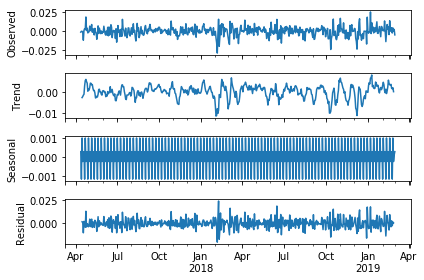

On  ENRO SS Equity  returns


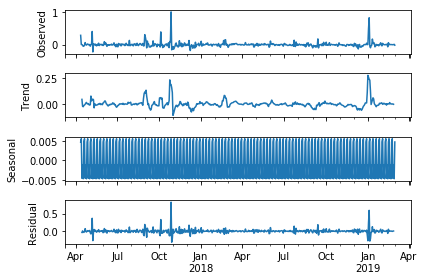

In [4]:
# EDA - Seasonality Issues
# We check for seasonality and trend in data using seasonal_decompose (SXXP v random stock)
# Stock selected based on highest annualized vol

print('- Extracting Seasonality & Trends - \n\nOn SXXP returns')
plt.close()
decomp_SXXP = sm.tsa.seasonal_decompose(sxxp[['SXXP_index']], model='additive')
decomp_SXXP.plot()
plt.show()
plt.close()
max_vol_index = desc.nlargest(1,'Annualized Vol').index.values[0]
print('On ',max_vol_index,' returns')
decomp_max_vol = sm.tsa.seasonal_decompose(raw_rets[[max_vol_index]],model='additive')
decomp_max_vol.plot()
plt.show()

#Series theoretically shows no trend as we study returns 
#Detrend if necessary
for series in raw_rets.columns: 
    raw_rets[series] = signal.detrend(raw_rets[series])

- Moving Averages - 
Initial Dataset:  (491, 1303) 
Post-cleaning Dataset:  (491, 920) 
Moving Average Dataset: (491, 920)


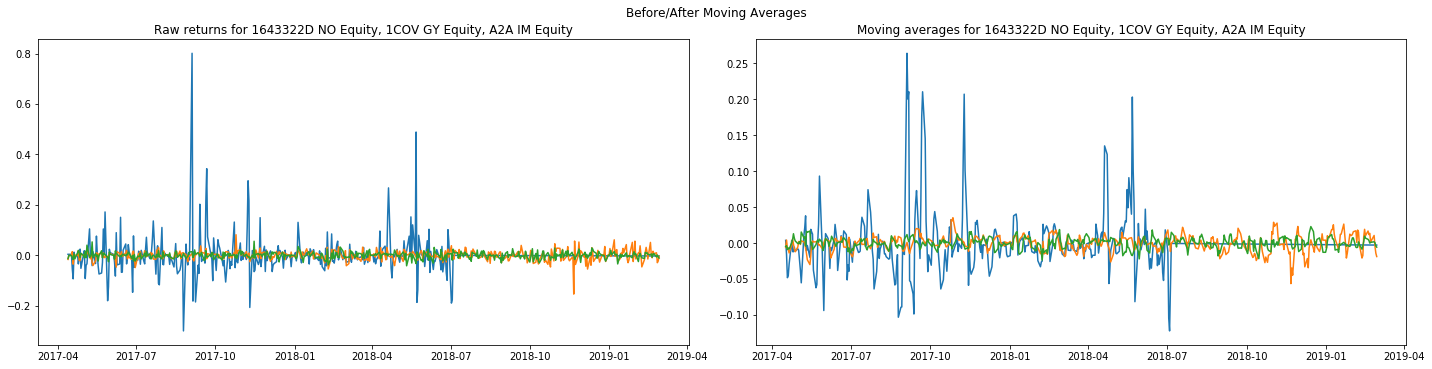

- Wavelets - 
Initial Dataset:  (491, 1303) 
Wavelets Dataset (Cleaned): (491, 1104)


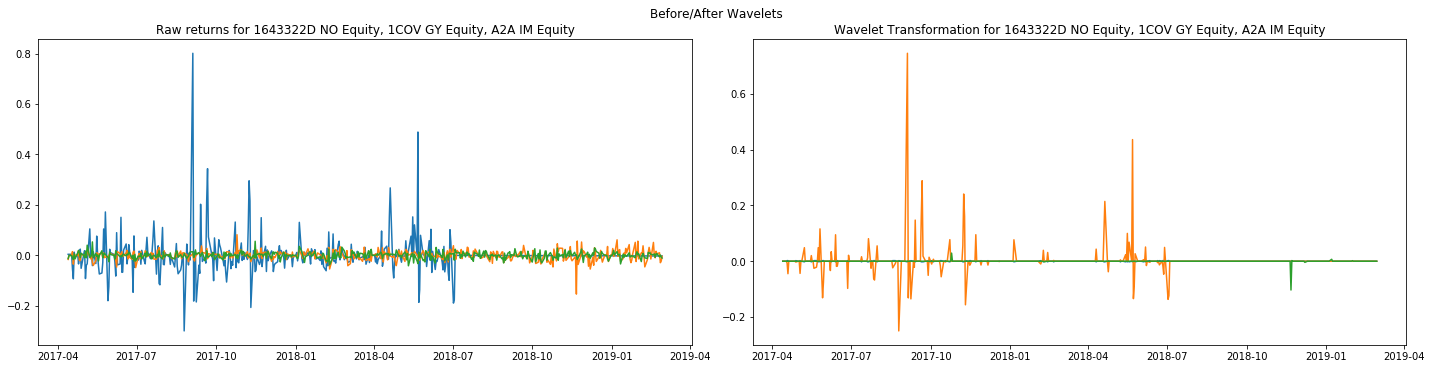

In [5]:
#Remove noise: moving average over 3 days
moving_avgs = pd.DataFrame({})
for series in raw_rets.columns: 
    moving_avgs[series] = raw_rets[series].rolling(window=3).mean()

#Double-Checking - Get shapes & plot 3 random stocks (before/after)
print('- Moving Averages - \nInitial Dataset: ',initial_shape,'\nPost-cleaning Dataset: ',raw_rets.shape,\
     '\nMoving Average Dataset:',moving_avgs.shape)
plt.close()
f, (ax1,ax2) = plt.subplots(1,2, sharey = False, figsize=(20,5))
f.suptitle('Before/After Moving Averages', va='bottom')
ax1.plot(raw_rets.iloc[:,0:3].index.values,raw_rets.iloc[:,0:3])
ax1.set_title('Raw returns for ' + ', '.join(list(raw_rets.iloc[:,0:3].columns.values)))
ax2.plot(moving_avgs.iloc[:,0:5].index.values,moving_avgs.iloc[:,0:3])
ax2.set_title('Moving averages for ' + ', '.join(list(moving_avgs.iloc[:,0:3].columns.values)))
plt.tight_layout()
plt.show()

#Remove noise : wavelet transform - scale = 0.44 (proved better results than ma in terms of prediction)
def denoise_wt(data,c): 
    (u, d) = wt.dwt(data, "haar") #apply discrete wavelet transform w/Haar 
    up_thresh = wt.threshold(u, np.std(u)/c, mode="soft")                
    down_thresh = wt.threshold(d, np.std(d)/c, mode="soft")   #remove all wavelets w/component dev > 1 sigma
    return wt.idwt(up_thresh, down_thresh, "haar") #apply inverse discrete wavelet transform

df = pd.read_excel('SXXP_returns.xlsx')
idx = df.index
df = pd.DataFrame(denoise_wt(df,0.44)).set_index(idx)
df = df.loc[:, (df != 0).any(axis=0)].copy()

#Double-Checking - Get shapes & plot 3 random stocks (before/after)
print('- Wavelets - \nInitial Dataset: ',initial_shape,
      '\nWavelets Dataset (Cleaned):',df.shape)

plt.close()
f, (ax1,ax2) = plt.subplots(1,2, sharey = False, figsize=(20,5))
f.suptitle('Before/After Wavelets', va='bottom')
ax1.plot(raw_rets.iloc[:,0:3].index.values,raw_rets.iloc[:,0:3])
ax1.set_title('Raw returns for ' + ', '.join(list(raw_rets.iloc[:,0:3].columns.values)))
ax2.plot(df.iloc[:,0:3].index.values,df.iloc[:,0:3])
ax2.set_title('Wavelet Transformation for ' + ', '.join(list(raw_rets.iloc[:,0:3].columns.values)))
plt.tight_layout()
plt.show()


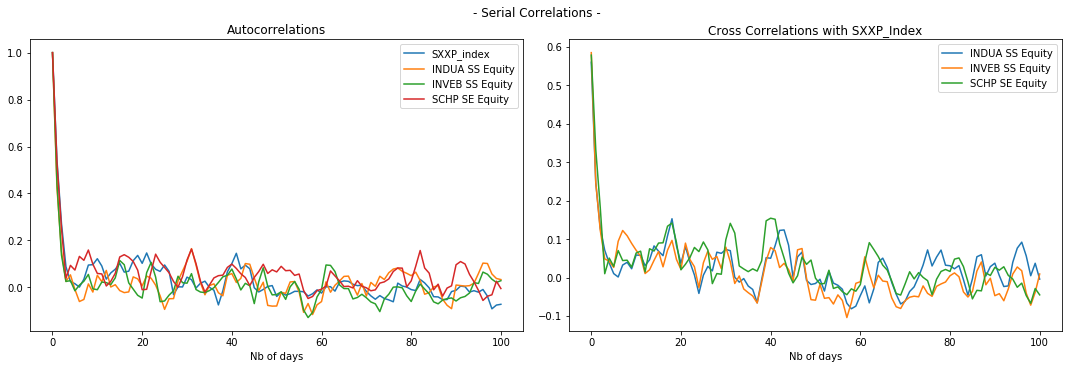

In [6]:
#Showing autocorrelations & Cross Correlations 

#Retrieve top 3 correlation coefs from corr table, get indexes
moving_avgs['SXXP_index'] = sxxp[['SXXP_index']].rolling(window=3).mean()
c = moving_avgs.corr().abs()[['SXXP_index']] 
unstacked = c.nlargest(4,'SXXP_index').index.values.tolist()
moving_avgs_filled = moving_avgs.fillna(moving_avgs.mean()) #Otherwise correlate returns NaN
def normalizedcrosscorr(a,b): #Based on np.correlate patch
    a = (a - np.mean(a)) / (np.std(a) * len(a))
    b = (b - np.mean(b)) / (np.std(b))
    return np.correlate(a,b,'full')

#Plotting abs cross corrs against SXXP with moving avg returns over 100 days
plt.close()
f, (ax1,ax2) = plt.subplots(1,2, sharey = False, figsize=(15,5))
f.suptitle('- Serial Correlations -', va='bottom')
for var in unstacked: 
    ax1.plot(np.arange(0,101,1), normalizedcrosscorr(moving_avgs_filled[var].abs(),moving_avgs_filled[var].abs())\
             [len(moving_avgs_filled[var])-1:len(moving_avgs_filled[var])+100],label=var)            
ax1.set_title('Autocorrelations')
ax1.set_xlabel('Nb of days')
ax1.legend()

#Plotting abs autocorrelations with moving avg returns over 100 days
unstacked.remove('SXXP_index')
for var in unstacked:
     ax2.plot(np.arange(0,101,1), normalizedcrosscorr(moving_avgs_filled['SXXP_index'].abs(),moving_avgs_filled[var].abs())\
             [len(moving_avgs_filled[var])-1:len(moving_avgs_filled[var])+100],label=var)         
ax2.set_title('Cross Correlations with SXXP_Index')
ax2.set_xlabel('Nb of days')
ax2.legend()
plt.tight_layout()
plt.show()

## Part III - Rolling PCA 

- df\returns et df\compo: splitter les deux df en fonction des valeurs de l’indicateur
- Pour chaque DataFrame splitté, supprimer les colonnes où un “0” est présent dans la composition. [Drop irrelevant columns, copy df before pca] 
- PCA sur chaque sous-df scalée avec nb arbitraire élevé de Pcs
- Calcul du nb de PCs nécessaires pour expliquer 80% de variance sur chaque df splitté 
- Max(nb PCs nécessaires) = nb de PCs à retenir sur la totalité de l’échantillon pour avoir un input de taille égale 
- Calcul des n composantes sur la totalité de l’échantillon à partir des eigenvectors sur chaque période
- Storer les rolling eigen values
- Une fois tous les PC de toutes les DataFrames obtenus, calculer pour chaque Row de chaque Dataframe scalée <Row[t] , PC_1>, <Row[t] , PC_2>, … ,  <Row[t] , PC_max>. Donne donc une matrice de nb_col = max et nb_lignes = nb de jours ouvrés présents dans la time window.
- Concaténer en lignes toutes les matrices obtenues. On obtient alors notre input pour les modèles à tester.
- Plot rolling eigenvalues against time 


In [7]:
df = pd.read_excel('SXXP_returns.xlsx')
idx = df.index
df = pd.DataFrame(denoise_wt(df,1)).set_index(idx)
df_comp = pd.read_excel("SXXP_Comp_returns.xlsx")
pca = PCA(n_components = 13)

c_change = [np.sum((df_comp.iloc[i+1]-df_comp.iloc[i])**2) != 0 for i in range(len(df_comp) -1)]
c_change.insert(0,0)

df_comp['indic_change'] = np.cumsum(c_change) #indicator function for a composition change
grp_comp = df_comp.groupby(df_comp['indic_change'],axis=0).groups #time dfs with stable composition
time_index = [pd.to_datetime(grp_comp[i]) for i in range(len(grp_comp))] #list of time indices for each subset

pca_ready_dfs = [] #list holdind the dfs for rolling PCA

for u in range(len(time_index)):
    curr_df = df.loc[time_index[u]] #current dataframe
    curr_comp = df_comp.loc[time_index[0]].iloc[0] #current index comp.
    for name in curr_df.columns:
        if curr_comp[name] == 0:
            curr_df.drop(name, axis=1, inplace=True)
            
    pca_ready_dfs.append(curr_df) #array storing the ready-to-use PCA inputs (last if we have to transform them)


all_inputs = [] #list holding the inputs

for x in pca_ready_dfs: #run the PCA for each df, store all the components (in value)
    pca.fit(x)
    #.dot is used to retrieve the component in value (<returns_(t), pc_1>, ... <returns_(t), pc_max> )
    curr_input = [[np.dot(x.iloc[i],pca.components_[j]) for i in range(len(x))] for j in range(len(pca.components_))]
    all_inputs = all_inputs + [curr_input]
    
#Final pcs - list merging the inputs turned into df 
final_inputs = [] #list merging the inputs
for j in range(13):
    cp_0 = [] 
    for i in range(len(all_inputs)):
        cp_0 += all_inputs[i][j]
    final_inputs +=[cp_0]
final_inputs = pd.DataFrame(final_inputs).transpose()

## Part IV Benchmarks - Random Forest

- Main idea: generate a random forest of binomial trees, compare against Y_train, find out which features reduce impurity the most.
- Add random to X: np.random.seed / np.random.random 
- Split dataset in training set vs. test set (0.7/0.3) using train_test_split 
- Choice of max_depth and n_estimators based on GridSearch. Max depth of tree = if none, all nodes are expanded until all leaves are pure or contain less than min_sample_leaf. N_estimators = nb of trees 
- Arbitrary hyperparameters: n_jobs = -1 (no limit), oob_score = False (we train and test the program independently), max_features = sqrt, random_state = 0 (ensures portability of results). All other hypers are set to default.
- Return: predictions for Y, spearman’s correlation coefficient (cleaner than Pearson’s, leave aside outliers), MSE, feature_importances

In [8]:
#del model_stats
#del pred_actual

In [9]:
#GridSearch for max_depth & n_estimators
def rfr_model(X, Y):
    gsc = GridSearchCV(
        estimator=RandomForestRegressor(),
        param_grid={
            'max_depth': range(5,15),
            'n_estimators': (10, 50, 100, 1000),
        },
        cv=5, scoring='neg_mean_squared_error', verbose=1,n_jobs=-1) 
    
    grid_result = gsc.fit(X, Y)
    global best_params
    best_params = grid_result.best_params_

#Random Forest - Set up (inputs shifted for lag = 1, standardization, randomization)
pcs_rf = final_inputs.iloc[:-1,:].copy()
srf = sxxp.drop('SXXP_cum',axis=1).iloc[1:,:].copy() 
predictions = pd.DataFrame()
np.random.seed(seed = 42)
pcs_rf['random'] = np.random.random(size = len(pcs_rf)) 
pcs_rf = StandardScaler().fit_transform(pcs_rf)
pcs_rf = pd.DataFrame(data=pcs_rf) #Convert back np array into df
pcs_rf_train, pcs_rf_test, srf_train, srf_test = train_test_split(pcs_rf, srf, test_size = 0.2, random_state = 42, shuffle = False) 

#Get optimal hyperparameters based on GridSearch 
rfr_model(pcs_rf_train,srf_train) 

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.7min finished


- Random Forest -
1000 trees were planted in 1.9386610984802246 seconds.
Spearman:  0.12943434246968663 
MSE:  6.641880427145458e-05 
Nb of features needed to reach 80% of importance: 8 out of 14 

      Importance  Cumulative_Importance
PCs                                   
11     0.137401               0.137401
5      0.124441               0.261842
1      0.113028               0.374870
2      0.100190               0.475059
8      0.083486               0.558546
10     0.075995               0.634541
6      0.061518               0.696058
3      0.054378               0.750437
7      0.053161               0.803597
4      0.050061               0.853658
13     0.045779               0.899436
12     0.036504               0.935941
0      0.033935               0.969876
9      0.030124               1.000000


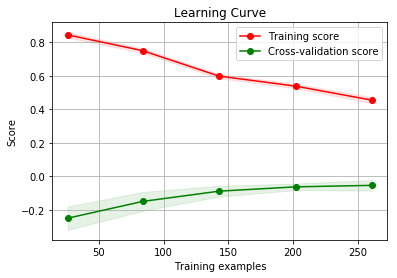

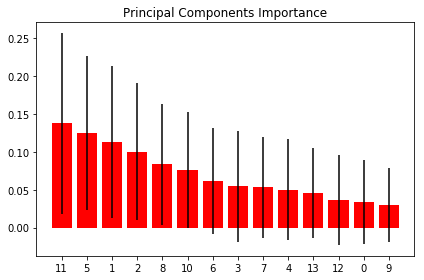

In [10]:
#Run the model with optimal parameters
start = time.time()
rfr = RandomForestRegressor(max_depth=best_params["max_depth"],
                            n_estimators=best_params["n_estimators"],
                            random_state=42,
                            verbose=0,
                            oob_score = False,
                            n_jobs=-1)

rfr.fit(pcs_rf_train,srf_train)
predictions['Random Forest'] = rfr.predict(pcs_rf_test) 
model_stats = pd.DataFrame()
model_stats = model_stats.append(pd.Series(['Random Forest', stats.spearmanr(srf_test, predictions['Random Forest']),
                                  mean_squared_error(srf_test, predictions['Random Forest'])]),\
                                 ignore_index=True)

end = time.time()
feature_importances = pd.DataFrame(rfr.feature_importances_,
                                 index = pcs_rf_train.columns,
                                 columns = [ 'Importance'])\
                                 .sort_values('Importance',ascending=False)
feature_importances['Cumulative_Importance'] = np.cumsum(feature_importances.iloc[:,0])
feature_importances.index.names = ['PCs']

#Return results - n_estimators, max depth, rf stats, feature importance
print('- Random Forest -')
print(best_params["n_estimators"], 'trees were planted in' , end-start, 
      'seconds.\nSpearman: ',model_stats.iloc[0,1][0],
      '\nMSE: ',model_stats.iloc[0,2],
      '\nNb of features needed to reach 80% of importance:', 
      len(feature_importances)-len(feature_importances[feature_importances['Cumulative_Importance'] >= 0.8].index.values.tolist()),'out of',
      len(feature_importances),'\n\n',feature_importances)

#Plotting learning curve & feature importance (12 = random)
plt.close()
skplt.estimators.plot_learning_curve(rfr, pcs_rf_train,srf_train).set_title('Learning Curve')
skplt.estimators.plot_feature_importances(rfr).set_title('Principal Components Importance')
plt.tight_layout()
plt.show()

## Part IV Benchmarks - XGBoost

- Turn relevant dsets into DMatrix 
- Perform gridsearch to get optimal learning rate/eta, max_depth, booster=gbtree 
- Set learning objective: reg:squarederror [default] 
- num_round = 100 (will early stop) + verbosity = 0 otherwise won’t run 
- Train w/ early stopping to retrieve best_ntreelimit based on eval_metrics = rmse 
- Get best prediction based on best_ntree_limit, store in predictions 
- Store metrics in model_stats 
- Plot importance to double-check A. 

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    8.2s finished


- XGBooster - 
100 trees were planted in 8.553540706634521 seconds.
Spearman: 0.0735316620709766 
MSE:  6.589357704723213e-05 
Nb of features needed to reach 80% coverage: 10 out of 13 

         Gain    Coverage  Cum Cover (%)
3   0.000050  152.324074       0.100842
8   0.000049  157.013333       0.204788
6   0.000049  101.826923       0.272200
12  0.000048   94.922078       0.335040
5   0.000047  126.493827       0.418782
2   0.000044  118.204545       0.497036
7   0.000043   66.218391       0.540874
11  0.000043  190.875000       0.667238
1   0.000038   51.739130       0.701490
4   0.000036  110.558559       0.774682
9   0.000035  122.533333       0.855802
10  0.000034  168.822785       0.967567
0   0.000026   48.991453       1.000000


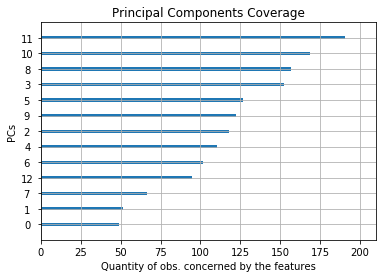

In [11]:
#XGBoost Set Up
pxg = final_inputs.iloc[:-1,:].copy()
sxg = sxxp.drop('SXXP_cum',axis=1).iloc[1:,:].copy() 
pxg_train, pxg_test, sxg_train, sxg_test = train_test_split(pxg, sxg, test_size = 0.2, random_state = 42, shuffle = False) 
dtrain = xgb.DMatrix(pxg_train, label=sxg_train)
dtest = xgb.DMatrix(pxg_test)
deval = xgb.DMatrix(pxg_test, label=sxg_test)
def xgb_search(X,Y): #gs for optimal eta, max depth 
    gsc = GridSearchCV(
        estimator= xgb.XGBRegressor(),
        param_grid={
            'max_depth': range(5,15),
            'learning_rate':(0.0001, 0.001, 0.01, 0.1, 0.2, 0.3),
        },
        cv=5, scoring='neg_mean_squared_error', verbose=1,n_jobs=-1) #5 fold validation
    
    grid_result = gsc.fit(X, Y)
    global best_params
    best_params = grid_result.best_params_

#Compile, fit, predict, get metrics 
start = time.time()
xgb_search(pxg_train, sxg_train) 
num_round = 100
params = {'max_depth': best_params['max_depth'], 
          'eta': best_params['learning_rate'], 
          'verbosity': 1, 
          'rate_drop': 0.2,
          'eval_metric':'rmse'}
bst = xgb.train(params, dtrain, num_round, evals=[(deval, 'test'),(dtrain, 'train')], verbose_eval=False, early_stopping_rounds=5)
predictions['XGBoost'] = pd.DataFrame(bst.predict(dtest, ntree_limit=bst.best_ntree_limit))
spr = stats.spearmanr(sxg_test, predictions['XGBoost'])
mse_xg = mean_squared_error(predictions['XGBoost'],sxg_test)
gain = pd.DataFrame.from_dict(bst.get_score(importance_type='gain'), orient='index',columns=['Gain']) #Improvement in accuracy brought by a feature to the branches it is on
gain = pd.merge(gain, pd.DataFrame.from_dict(bst.get_score(importance_type='cover'), #Coverage = relative quantity of observations concerned by a feature
                orient='index',columns=['Coverage']),left_index = True, right_index=True).sort_values(by=['Gain'],ascending = False)
gain['Cum Cover (%)'] = (np.cumsum(gain.iloc[:,1]))/gain.Coverage.sum() 
model_stats = model_stats.append(pd.Series (['XGBoost',spr,mse_xg]), ignore_index=True) 
end = time.time()

#Return results - plot importance 
print('- XGBooster - ')
print(bst.best_ntree_limit,'trees were planted in',end-start,
      'seconds.\nSpearman:',spr[0],'\nMSE: ',mse_xg,'\nNb of features needed to reach 80% coverage:',
      len(gain)-len(gain[gain['Cum Cover (%)'] >= 0.8].index.values.tolist()),'out of', len(gain),'\n\n',gain)
plt.close()
xgb.plot_importance(bst,importance_type = 'cover', ylabel = 'PCs', xlabel='Quantity of obs. concerned by the features', title='Principal Components Coverage', show_values=False)
plt.show()

## Part IV Benchmarks - Shallow NN

- Import sequential from models, dense/dropout/activation from layers, metrics from keras
- Create sequential() and add 3x dense layers with activation functions = ELU partout, linear en output, Input_dim = max(PCs), Nb neurons = features/22/1, kernel_constraints = maxnorm(4) (limits size of network weights using max-norm regularization, usually shows better results) 
- Dropout: trial and error for best rate (0.2/0.4/0.6)
- Compile with hyperparameters:
- Gradient descent: Adam rather than rmsprop (safe choice)
- Loss function: ‘mean_squared_error’ (typical for reg)
- Metrics : [‘mse’] (full list available here: https://keras.io/losses/) 

Fit with hyperparameters:
- Epochs: 100 w/ early stopping callback [Forward/backward passes]
- Batch size: has to be chosen arbitrarily - 20 in Bovespa
- Verbose: 0 (otherwise won’t run in Jupyter)
- Return: Y_pred, performance metrics - mse, spearman -  using model.evaluate(X_test, Y_test) 
- Store Y_pred in Df ‘Predictions’ alongside what was obtained previously

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
- FFNN -
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 13)                182       
_________________________________________________________________
dropout (Dropout)            (None, 13)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 22)                308       
_________________________________________________________________
dropout_1 (Dropout)          (None, 22)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)          

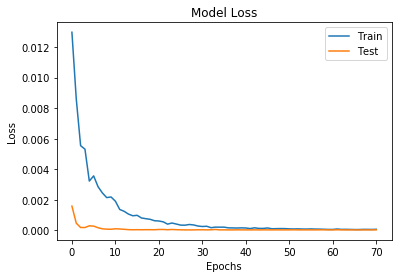

In [12]:
# Keras Shallow - Prep up 
pcs_ks = final_inputs.iloc[:-1,:].copy()
pcs_ks = StandardScaler().fit_transform(pcs_ks)
sks = sxxp.drop('SXXP_cum',axis=1).iloc[1:,:].copy() 
pcs_ks_train, pcs_ks_test, sks_train, sks_test = train_test_split(pcs_ks, sks, test_size = 0.2, random_state = 42, shuffle = False)

#Model architecture
ks = Sequential()
ks.add(Dense(13, input_dim=13, kernel_initializer='normal', activation='elu', kernel_constraint= max_norm(4)))
ks.add(Dropout(0.2))
ks.add(Dense(22, activation='elu'))
ks.add(Dropout(0.2))
ks.add(Dense(1, activation='linear'))

#Compile, fit, predict, get metrics 
opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
ks.compile(loss='mean_squared_error', optimizer=opt, metrics=['mean_squared_error']) #spearman_custom added manually below
cb_earlystopping = EarlyStopping(monitor='mean_squared_error', min_delta=0, patience=5, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
history = ks.fit(pcs_ks_train, sks_train, epochs=100, batch_size=20,  verbose=0, validation_split=0.2, callbacks =[cb_earlystopping])
predictions['Shallow NN'] = ks.predict(pcs_ks_test)
print('- FFNN -')
ks.summary()
model_stats = model_stats.append(pd.Series (['Shallow NN', stats.spearmanr(srf_test, predictions['Shallow NN']), ks.evaluate(pcs_ks_test, sks_test)[1]]), ignore_index=True) 
                  
#Display decreasing losses against epochs 
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

## Part IV - LSTM

- First reframe the problem into a Supervised Learning Problem 
- The input features for the LSTM will be SXXP[t-1] , PC1[t-1], … , PCmax[t-1]
- Reshape everything so as to fit LSTM dimensions ([samples, timesteps, features]) 
- Optimal denoising C for RMSE = 1.3 (for current model with hidden state dimension = 50)
- Optimal denoising C for accuracy (60%) = 0.44
- Fine tuning w/ hyperas?

- LSTM - 
98/98 [==============================] - 0s 56us/sample - loss: 0.0217
200 epochs ran in 9.690902471542358 seconds.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                13000     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 13,051
Trainable params: 13,051
Non-trainable params: 0
_________________________________________________________________


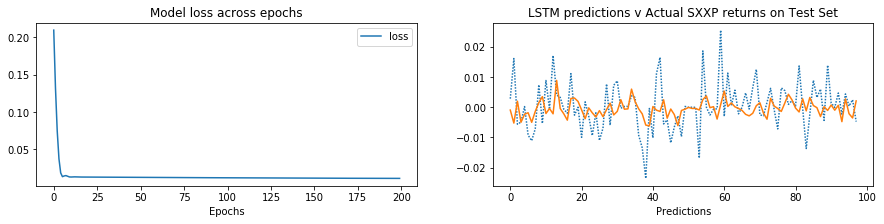

In [13]:
warnings.simplefilter('ignore')

#Preprocessing LSTM
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True): #convert pb to SLP
    
    n_vars = 1 if type(data) is list else data.shape[1]
    df = data
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

def compute_lstm_results(predictions):
    
    start = time.time()
    sxxp = pd.read_excel("sxxp_returns_solo.xlsx")
    final_inputs.set_index(sxxp.index,drop=True,inplace=True)
    final_inputs.rename(index=str, columns={i:"pc_{}".format(i) for i in range(13)},inplace=True)

    #concatenate the sxxp and principal components df
    train_set = pd.concat([sxxp,final_inputs], axis=1, join='outer')

    #Preprocessing the data
    #Reframing the problem into a SLP.
    #Splitting the ds into test, train
    #Reshaping everything into LSTM dimension
    #Rescale the data using MinMaxScaler

    values = train_set.values
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = pd.DataFrame(scaler.fit_transform(values))
    reframed = series_to_supervised(scaled, 1, 1)

    #Drop the unnecessary columns (the PCs[t])
    ldrop = [i for i in range(15,28)]
    reframed.drop(reframed.columns[ldrop], axis=1, inplace=True)

    # Split the data into training and test sets. Taking 80% as training set and 20% as test set

    n_samples = int(len(reframed)*0.8) 
    values = reframed.values
    train = values[:n_samples, :]
    test = values[n_samples:, :]
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]

    # Reshape everything into LSTM dimension

    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

    # Model Specification (LSTM) - Training
    model = Sequential()
    model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    cb_es_lstm = EarlyStopping(monitor='loss', min_delta=0, patience=10, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
    cb_csv_lstm = CSVLogger('lstm_log.csv', separator=',', append=False)
    history = model.fit(train_X, train_y, epochs=200, batch_size=72, validation_data=(test_X, test_y), verbose=0, shuffle=False, callbacks =[cb_es_lstm, cb_csv_lstm])

    # Model Predictions
    # Predict the test set
    
    yhat = model.predict(test_X)
    global score_lstm
    score_lstm =  model.evaluate(test_X, test_y, batch_size=72)
    #Reshape test set in initial shape
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2])) 
    #Concatenate the prediction with the test X, rescale all back then keep only the first column

    #Rescale the y_predicted
    inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]

    #Rescale the y_actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    
    #Compute Model RMSE, plot model loss and actual/predicted
    end = time.time()
    print(len(history.history['loss']),'epochs ran in',end-start, 'seconds.')
    model.summary()
    csv_log = pd.read_csv('lstm_log.csv')
    csv_log.drop('epoch', axis=1,inplace=True)
    plt.close()
    f, (ax1,ax2) = plt.subplots(1,2, figsize=(15,3))
    ax1.plot(csv_log.iloc[:,0], label=csv_log.columns.values[0])
    ax1.set_title('Model loss across epochs')
    ax1.set_xlabel('Epochs')
    ax1.legend()
    ax2.plot(inv_y, dashes=[1,1])
    ax2.plot(inv_yhat)
    ax2.set_xlabel('Predictions')
    ax2.set_title('LSTM predictions v Actual SXXP returns on Test Set')
    plt.show()
    predictions['LSTM'] = inv_yhat
    return predictions


#Return results 
print('- LSTM - ')
compute_lstm_results(predictions)
model_stats = model_stats.append(pd.Series (['LSTM', stats.spearmanr(srf_test, predictions['LSTM']),pow(score_lstm,2)]), ignore_index=True) 

                                            Spearmans Corr       MSE      RSME
Model                                                                         
Random Forest   (0.12943434246968663, 0.20399729226530539)  0.000066  0.008150
XGBoost           (0.0735316620709766, 0.4717950097456193)  0.000066  0.008117
Shallow NN     (0.19690265496730863, 0.051980339170416064)  0.000061  0.007823
LSTM             (0.13498125532859148, 0.1851130936659973)  0.000470  0.021683


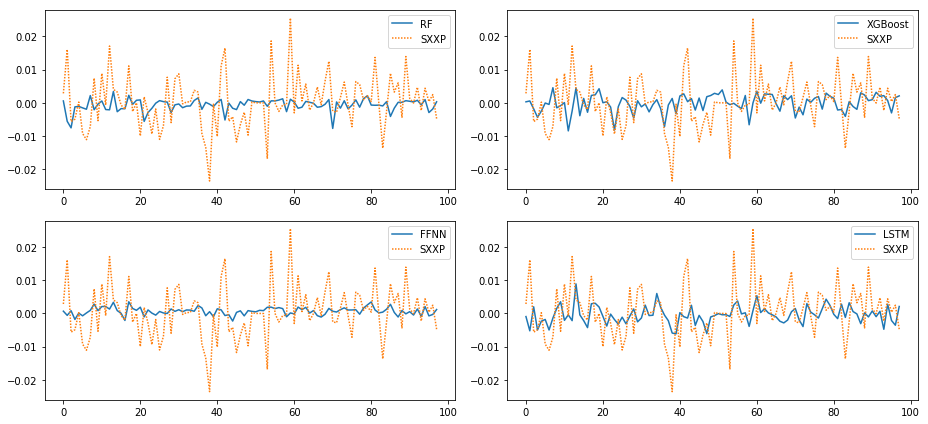

In [14]:
#Comparative Analysis with model_stats, predictions, chart  
model_stats.rename(columns={0:'Model', 1:'Spearmans Corr', 2:'MSE'}, inplace=True)
model_stats['RSME'] = np.sqrt(model_stats.MSE)
model_stats.set_index('Model',drop=True,inplace=True)
print(model_stats)
sks_test.reset_index(drop=True, inplace=True)
pred_actual = pd.concat([predictions, sks_test], 1, ignore_index=True)
pred_actual.rename(columns={0:'RF',1:'XGBoost',2:'FFNN',3:'LSTM'},inplace=True)

plt.close()
f = plt.figure(figsize=(13,6))
for i in range(1,5): 
    plt.subplot(2,2,i) 
    plt.plot(sks_test.index.values,pred_actual.iloc[:,i-1],label=pred_actual.columns.values[i-1])
    plt.plot(sks_test.index.values , pred_actual.iloc[:,-1], label='SXXP',dashes=[1,1])
    plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

## Part V - Long/Short 

In [17]:
df = pd.read_excel("preds.xlsx")
dfpred = df.drop("SXXP",axis=1)
dfrets = df["SXXP"]
cons = {'type':'eq', 'fun': lambda u:np.sum(u)-1} #Optimization constraints on weights
vInd = np.vectorize(lambda u:u/abs(u))

##### Misc Functions #####

def window_split(df,size): #splits the dataframe into overlapping rolling windows of given size
    return [df.iloc[i:size+i] for i in range(len(df)-size)]

def ann_sharpe(rets):
    return np.sqrt(252) * rets.mean() / rets.std()

def ann_return(x):
    cpd = np.cumprod(1+np.array(x))
    return (cpd[-1]/cpd[0])**(252/len(x)) - 1

def MDD(rets): #Metric 3 : Max DD
    maxrets = np.maximum.accumulate(rets)
    draws = 1 - rets/ maxrets
    return np.max(draws)

##### Metric Functions for weights optimization #####

def cpd_return(weights,*window): #Metric 1 : Compound Return
    
    preds = np.array(window[0].drop("SXXP",axis=1))
    rets = np.array(window[0]["SXXP"])
    #pos = np.tanh(np.dot(preds,weights))  #tanh activation
    pos = np.dot(preds,weights)          #identity activation
    return -np.cumprod(1+rets*pos)[-1]

def sharpe_ratio(weights,*window): #Metric 2 : Sharpe Ratio
    
    preds = np.array(window[0].drop("SXXP",axis=1))
    rets = np.array(window[0]["SXXP"])
    
    pos = np.tanh(np.dot(preds,weights))  #tanh activation
    #pos = np.dot(preds,weights)          #identity activation
    return -ann_sharpe(pos)

def max_drawdown(weights,*window): #Metric 3 : Max Drawdown
    
    preds = np.array(window[0].drop("SXXP",axis=1))
    rets = np.array(window[0]["SXXP"])
    
    pos = np.tanh(np.dot(preds,weights))  #tanh activation
    #pos = np.dot(preds,weights)          #identity activation
    return MDD(pos)

#,constraints=cons

##### Optimization Functions #####

def optimize_weights(metric,window): #Optimize a given metric in a given window - semi LS as optim, .x to retrieve 
    return minimize(metric, [0,1,0,0],method='SLSQP',args=(window,),bounds =((0, 1),) *4).x 

def mass_optim(metric,size): #Return the full list of weights for a given function and a given window size
    global df
    spl = window_split(df,size)
    return [np.array(optimize_weights(metric,spl[i])) for i in range(len(spl))]

#### Optimize for what metric and what window size ? ---> Change the metric to any function applied to the window ####

# current_metric belongs in [cpd_return,ann_sharpe,max_drawdown]

def get_all_stats(current_metric,wsize,plot=True):
    
    #global dfpred
    #global dfrets

    current_optim = mass_optim(current_metric,wsize)
    positions = np.array([np.dot(dfpred.iloc[wsize+i],current_optim[i]) for i in range(len(current_optim))])
    rets_sxxp = dfrets.iloc[wsize:] #returns of SXXP in the remaining frames
    rets_longshort = dfrets.iloc[wsize:]*positions #returns of LS strategy using cpd ret optimization
    
    d = {"SXXP Strategy":rets_sxxp,"SXXP Long-Short Strategy":rets_longshort}
    
    for u,v in d.items():

        print("#### {} ####, window size = {} \n".format(u,wsize))

        for fun in [ann_return,ann_sharpe,MDD]:
            print( "{} {} : {} ".format(u,fun.__name__,fun(v)))

        print("\n")
        
    if plot == True:
            
        plt.plot(np.cumprod(1+rets_sxxp),dashes=[1,1],label="Cpd. Returns SXXP")
        plt.plot(np.cumprod(1+rets_longshort),label="Cpd. Returns opt. LS")
        plt.legend()
        plt.show()

get_all_stats(max_drawdown,40,True)

KeyError: "['SXXP'] not found in axis"